In [22]:
import laspy
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Loading

In [33]:
las = laspy.read('data/HT412_1743085214_3237183_1427127638184903_1427127806163693.las')
las

<LasData(1.2, point fmt: <PointFormat(0, 0 bytes of extra dims)>, 64677749 points, 1 vlrs)>

In [34]:
data = np.stack([las.X, las.Y, las.Z, las.intensity, las.scan_angle_rank, las.user_data, las.point_source_id], axis=0).T
data = pd.DataFrame(data)
data.columns = ['X',
                'Y',
                'Z',
                'intensity',
                'scan_angle_rank',
                'user_data',
                'point_source_id']

In [35]:
data.head()

X   Y  Z  intensity  scan_angle_rank  user_data  point_source_id
0    0   0  0         11               50          0                1
1  -89  19  0         17               50          0                3
2 -185  41 -3         15               50          0                5
3 -281  61  0         12               50          0                7
4 -386  83  0         14               49          0                9

# Visualizing Raw

In [36]:
intensities = data['intensity']
norm_intensities = (intensities - intensities.min()) / (intensities.max() - intensities.min())
colors = np.stack([norm_intensities]*3, axis=1)

In [37]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(data.iloc[:10000000, :3].values)
geom.colors = o3d.utility.Vector3dVector(colors[:10000000])
o3d.visualization.draw_geometries([geom])

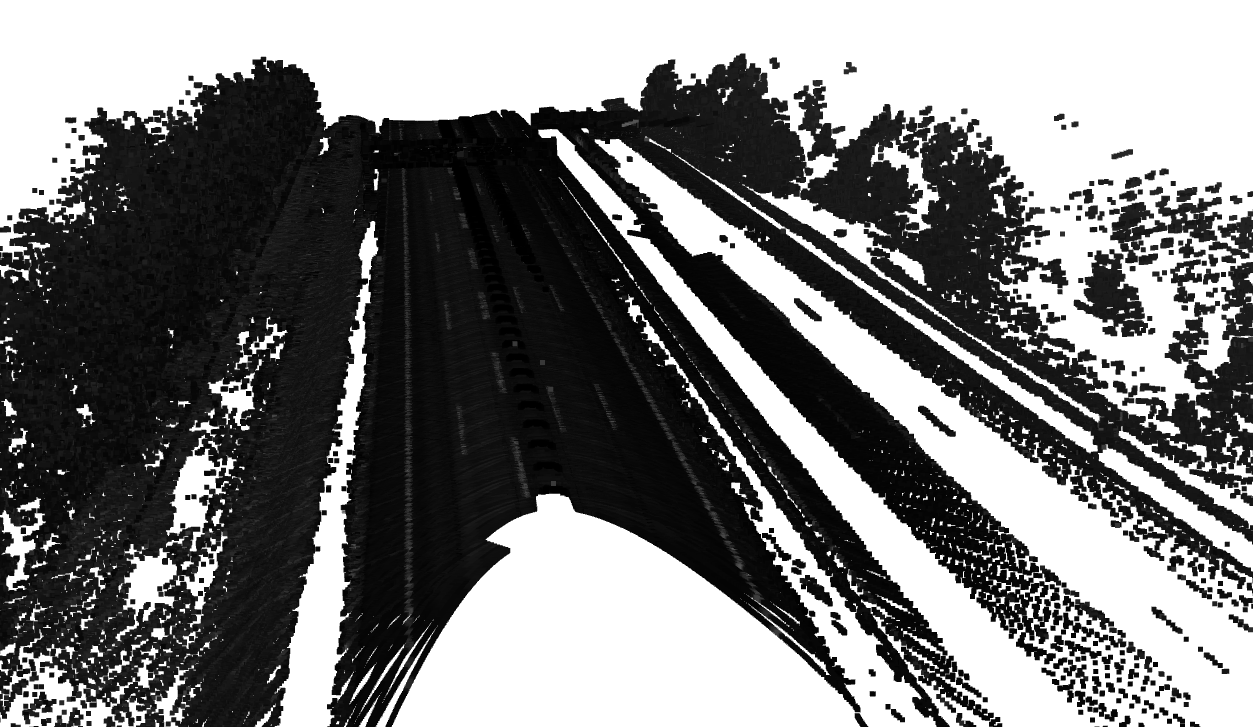
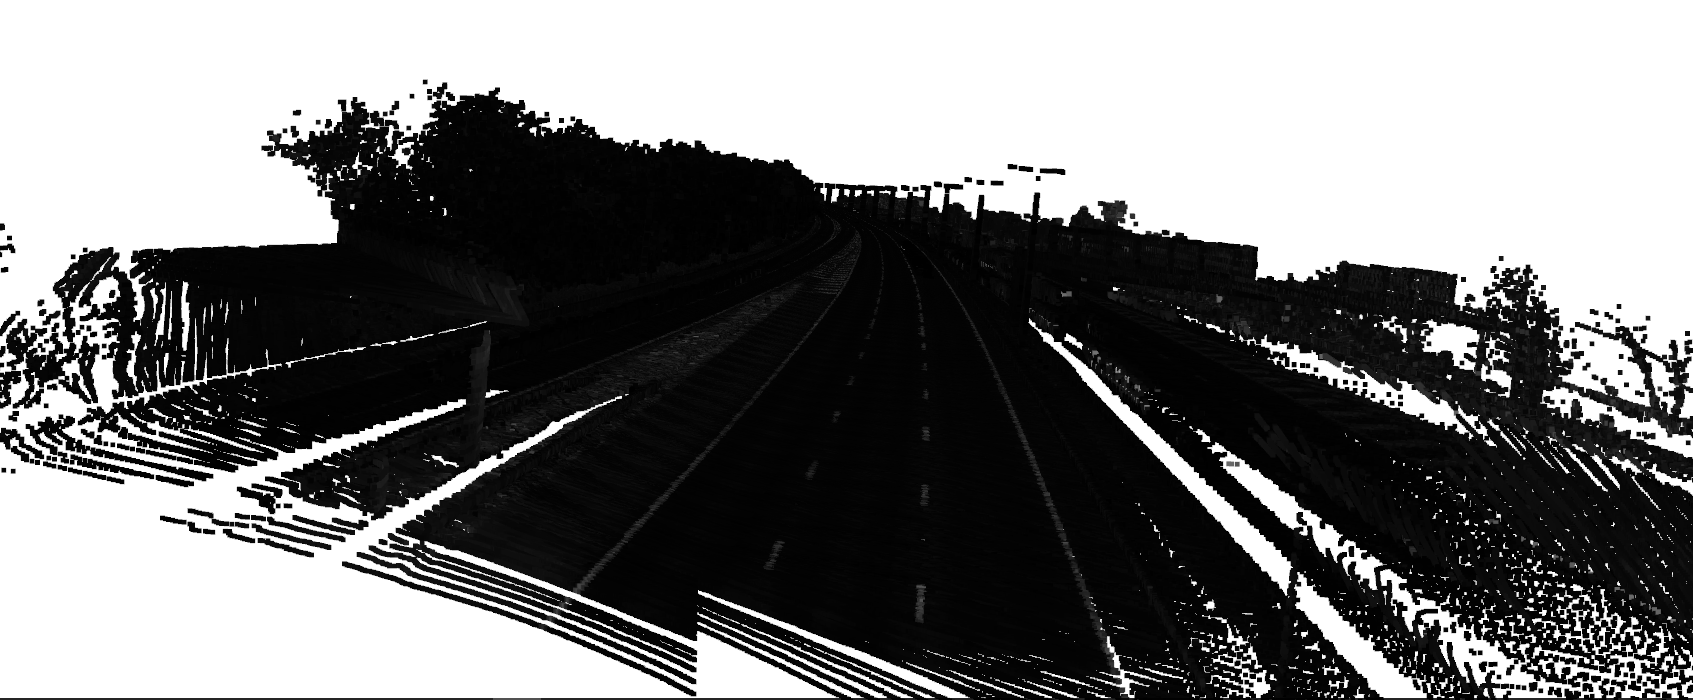
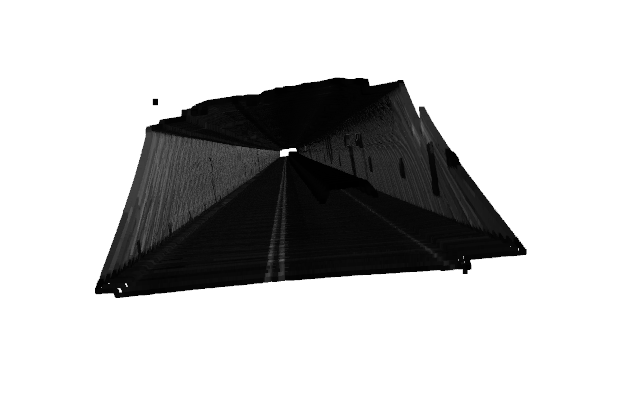

# Removing Noise

In [38]:
geom_clean, _ = geom.remove_statistical_outlier(nb_neighbors=400, std_ratio=0.6)
len(geom_clean.points)

8587366

In [39]:
o3d.visualization.draw_geometries([geom_clean])

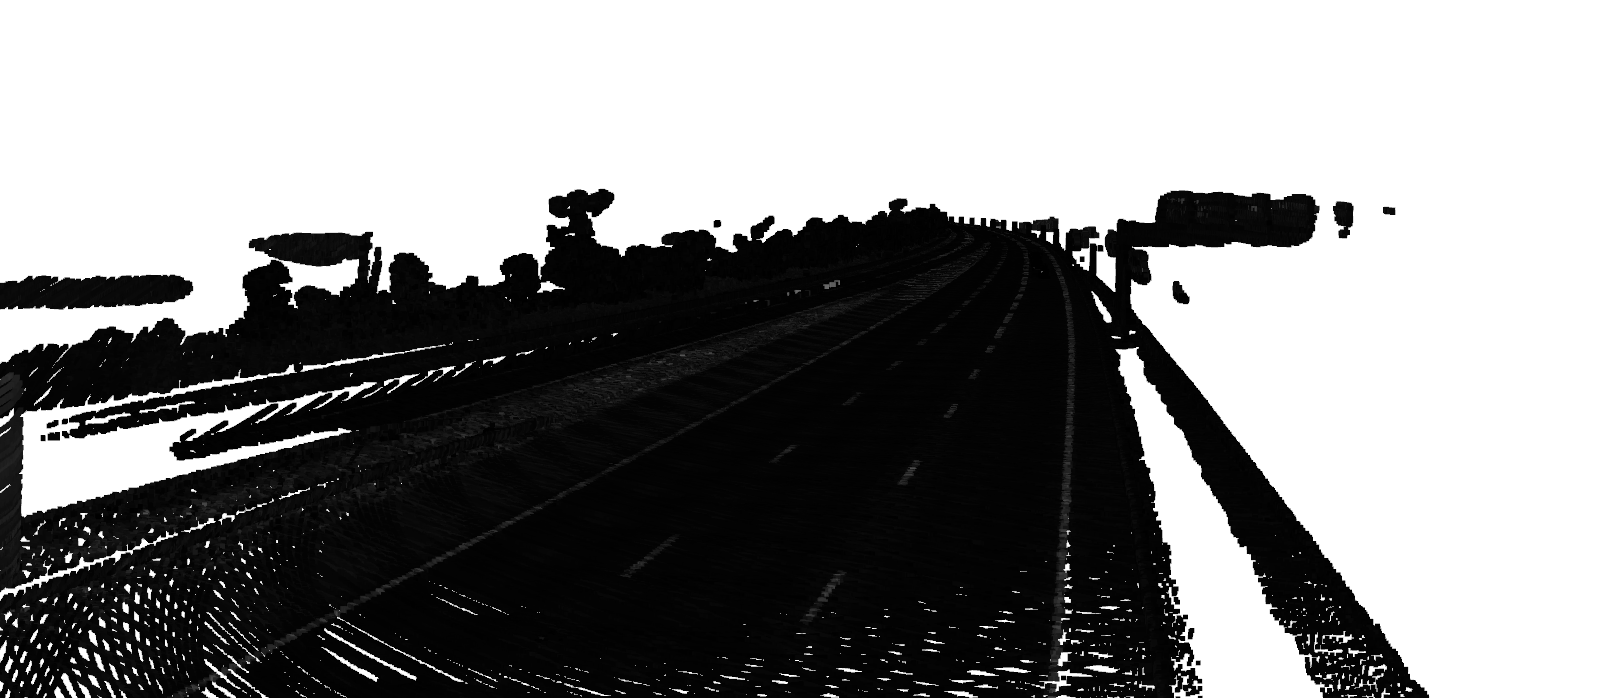
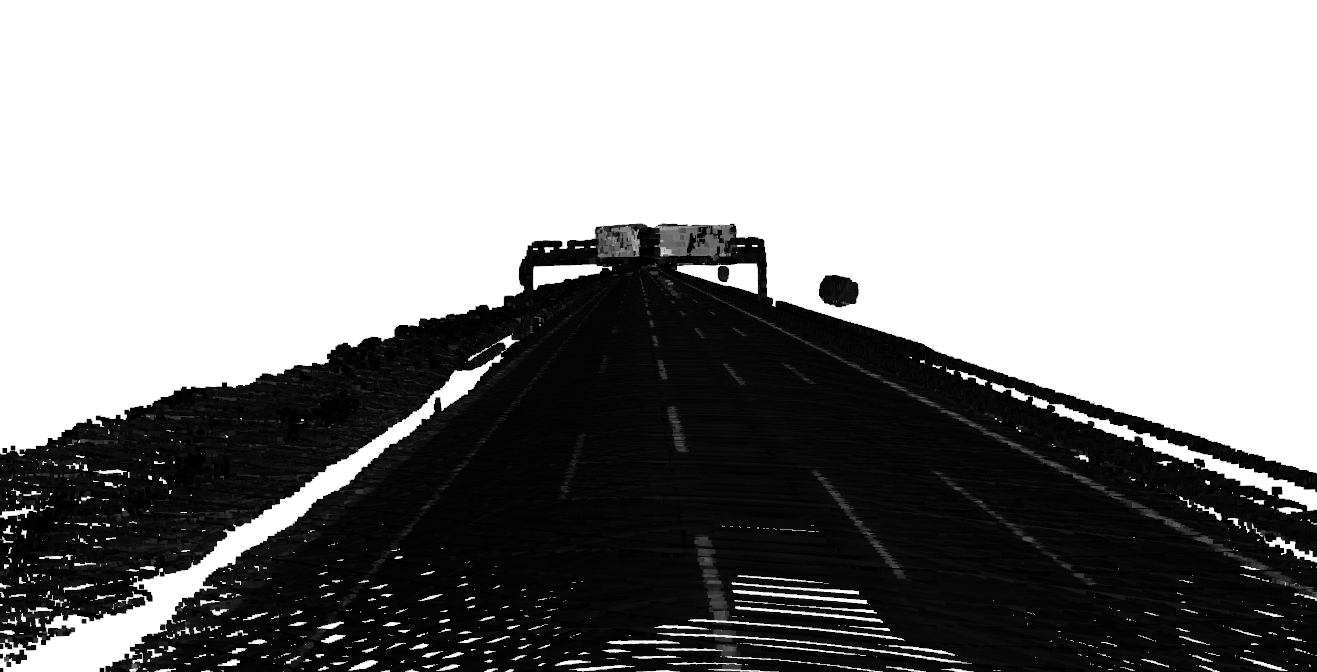

# Extracting Ground from Non-Ground

In [40]:
plane_model, inliers = geom.segment_plane(distance_threshold=200, ransac_n=3, num_iterations=10000)

In [41]:
ground_cloud = geom.select_by_index(inliers)
non_ground_cloud = geom.select_by_index(inliers, invert=True)

## Ground

In [46]:
geom_ground_clean, _ = ground_cloud.remove_statistical_outlier(nb_neighbors=400, std_ratio=0.6)
o3d.visualization.draw_geometries([geom_ground_clean])

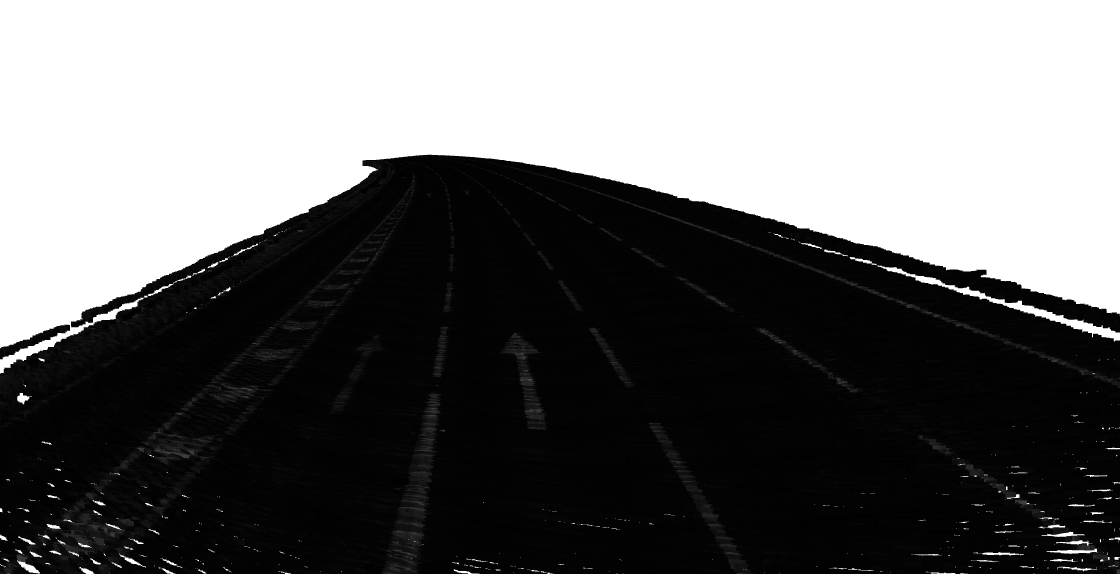
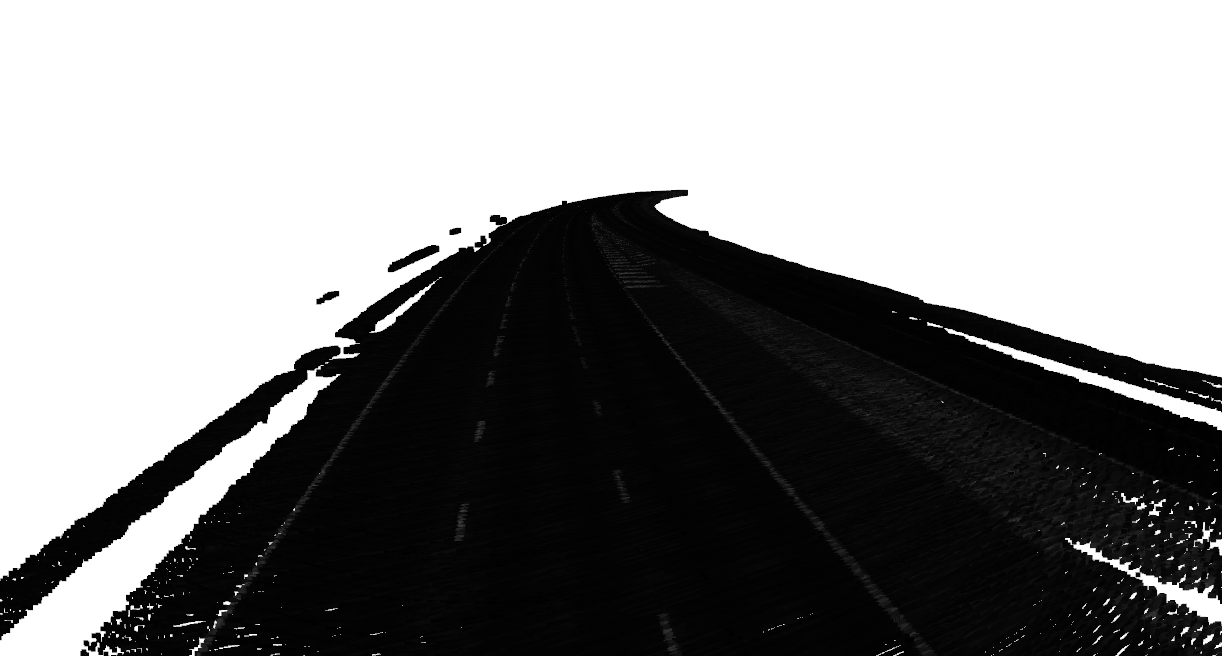
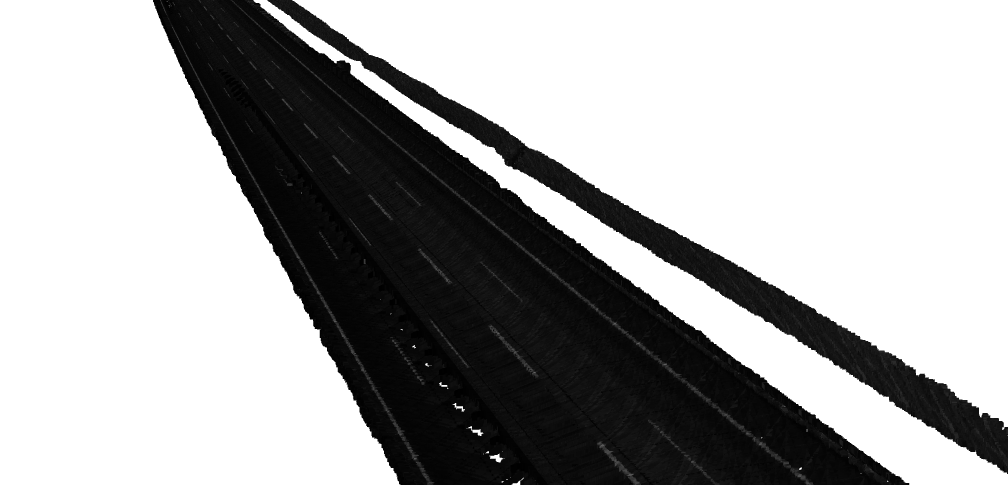

## Non-Ground

In [45]:
o3d.visualization.draw_geometries([non_ground_cloud])

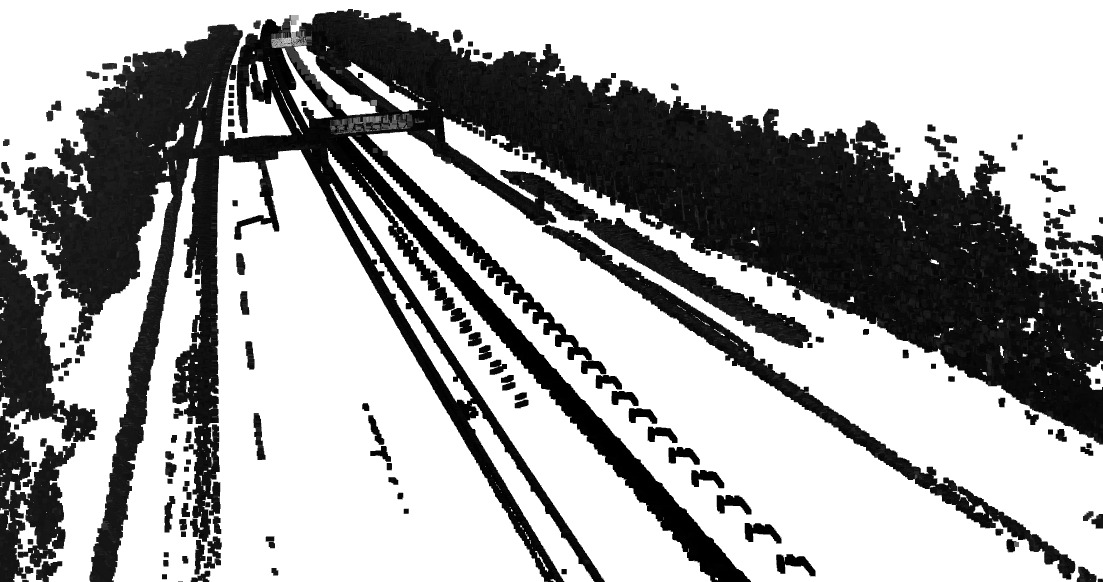

# Comparison

![file_2025-08-07_12.24.50[1].png](attachment:f997de0b-09e7-4090-b2e1-5d8215cedc72.png)
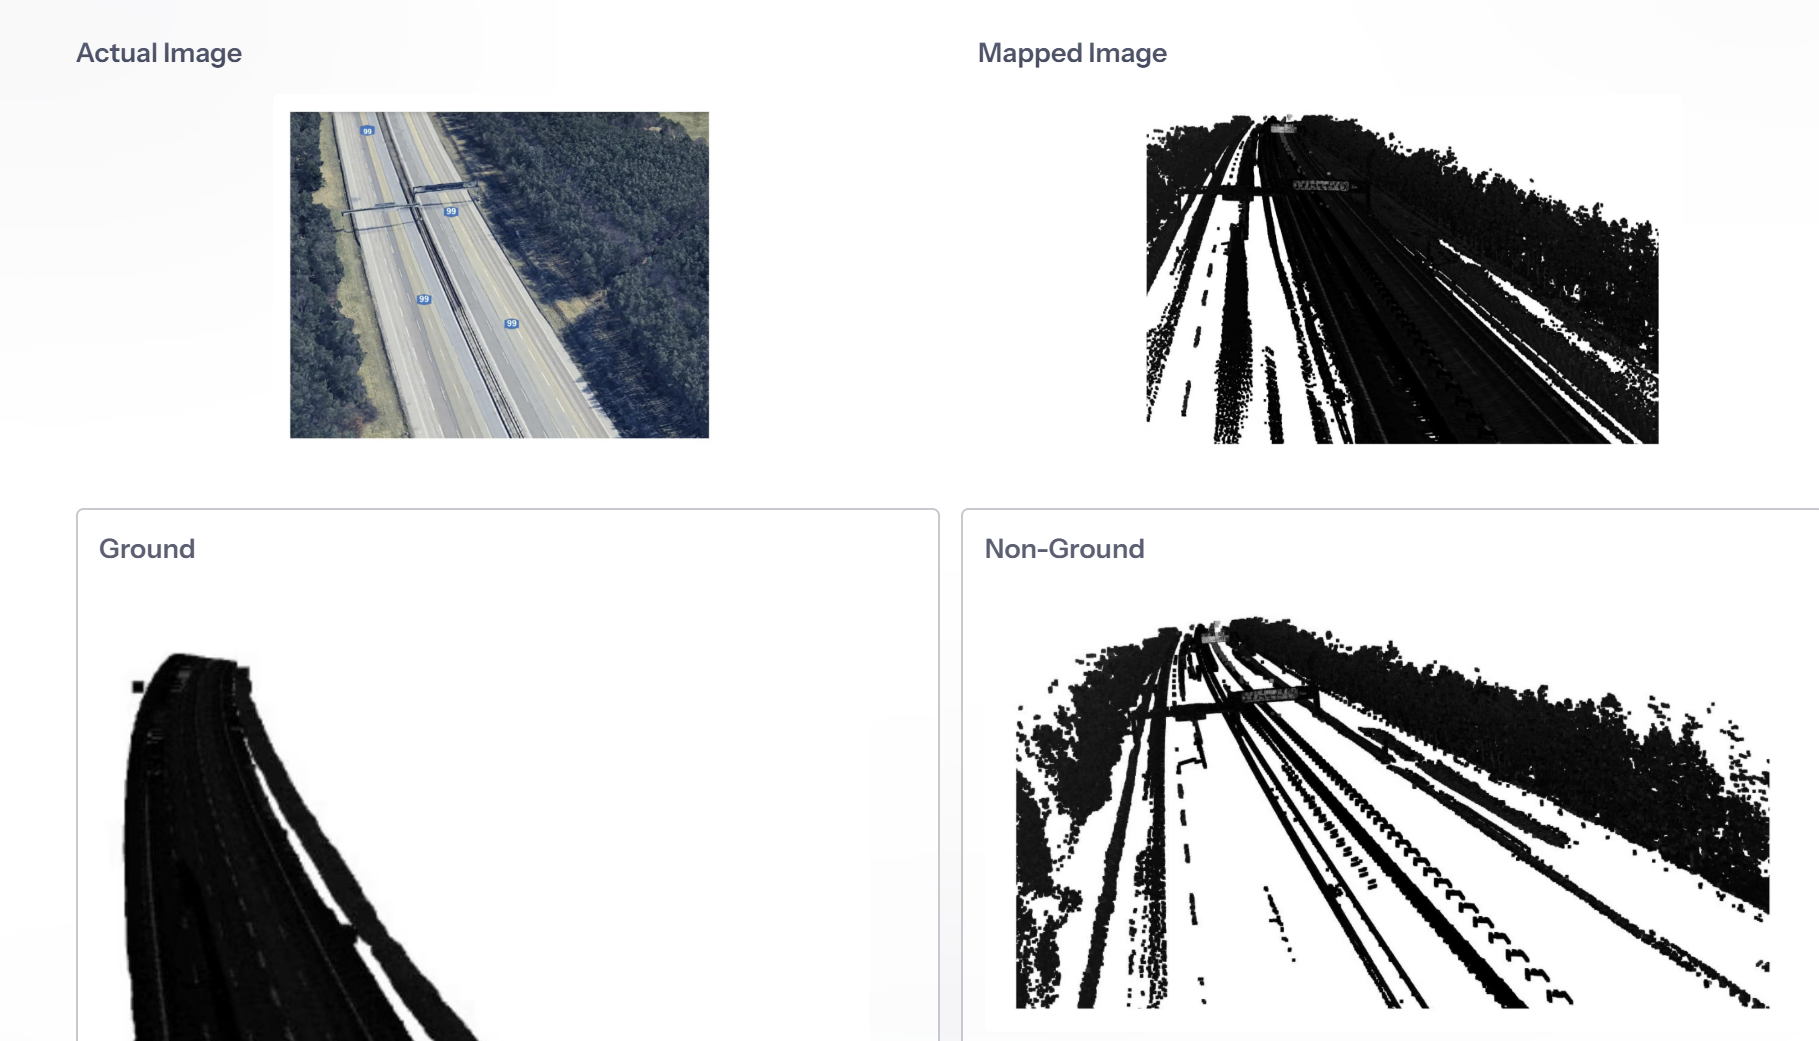

## Lane Markers

In [12]:
ground_points = np.asarray(ground_cloud.points)

rounded_data_coords = np.round(data.iloc[:10000000, :3].values, 3)
rounded_ground_coords = np.round(ground_points, 3)

# Build set for lookup
ground_set = set(map(tuple, rounded_ground_coords))

ground_mask = np.array([tuple(pt) in ground_set for pt in rounded_data_coords])
ground_intensities = intensities[:10000000][ground_mask]
ground_colors = colors[:10000000][ground_mask]

threshold = np.percentile(ground_intensities, 99)
markings_mask = ground_intensities >= threshold
marking_points = ground_points[markings_mask]
marking_colors = ground_colors[markings_mask]

# Step 4: Create marking point cloud
markings_cloud = o3d.geometry.PointCloud()
markings_cloud.points = o3d.utility.Vector3dVector(marking_points)
markings_cloud.colors = o3d.utility.Vector3dVector(marking_colors)

# Visualize road markings
o3d.visualization.draw_geometries([markings_cloud], window_name="Road Markings (High Intensity)")

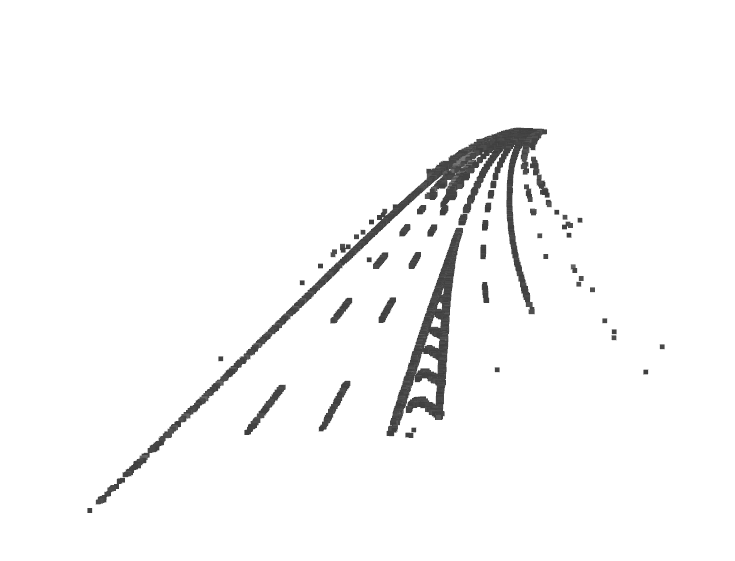
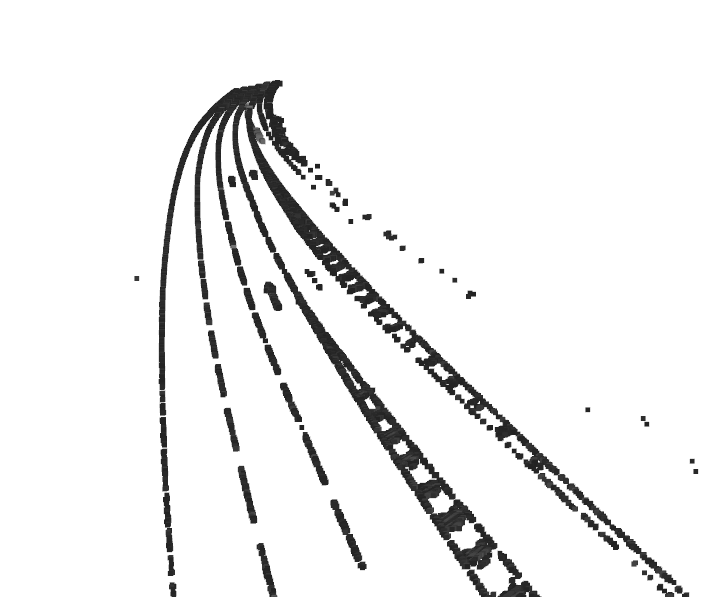
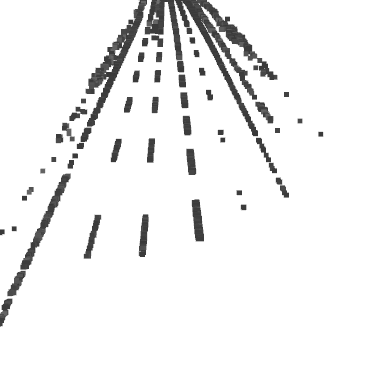